# FPGA Audio Denoising System (FFT + Spectral Subtraction)

This notebook demonstrates a hardware-accelerated audio denoising pipeline on PYNQ-Z2.

**System Pipeline:**
`Time Domain Audio` -> `DMA` -> `FFT IP` -> `Denoise IP` -> `DMA` -> `Frequency Domain Data` -> `Python IFFT` -> `Audio`

**Key Features:**
* **SSR=2**: Super Sample Rate processing (2 samples per clock).
* **Spectral Subtraction**: Hardware implementation of magnitude-based denoising.
* **Dynamic Configuration**: Adjustable `alpha` (subtraction strength) and `beta` (spectral floor).

In [1]:
from pynq import Overlay, allocate
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import write as wav_write
import time
import ipywidgets as widgets
from IPython.display import display, Audio

# 1. Load the Overlay
overlay = Overlay("audio_denoise.bit")
dma = overlay.axi_dma_0
fft_ip = overlay.fft_top_0
denoise_ip = overlay.denoise_top_0

# Check if IPs are available
print("Overlay loaded successfully!")
print("FFT IP Status:", fft_ip.read(0x00))
print("Denoise IP Status:", denoise_ip.read(0x00))

Overlay loaded successfully!
FFT IP Status: 4
Denoise IP Status: 4


In [2]:
# 2. Driver Class for Denoise IP
# Maps the register offsets from HLS C++ definition to Python methods

class DenoiseDriver:
    def __init__(self, ip_handle):
        self.ip = ip_handle
        # Register Offsets (Standard Vitis HLS AXI-Lite mapping)
        self.ADDR_CTRL = 0x00
        self.ADDR_ALPHA = 0x10        # magnitude_t (ap_ufixed<16,8>)
        self.ADDR_BETA = 0x18         # magnitude_t (ap_ufixed<16,8>)
        self.ADDR_ENABLE = 0x20       # ap_uint<1>
        self.ADDR_RESET_NOISE = 0x28  # ap_uint<1>
        self.ADDR_FRAME_CNT = 0x30    # ap_uint<4>
        
    def start(self):
        # Bit 0: Start, Bit 7: Auto-restart
        self.ip.write(self.ADDR_CTRL, 0x81)
        
    def configure(self, alpha=2.5, beta=0.05, enable=True):
        # Convert float to fixed-point <16, 8> representation
        # Value = Float * 2^8
        alpha_fixed = int(alpha * 256)
        beta_fixed = int(beta * 256)
        
        self.ip.write(self.ADDR_ALPHA, alpha_fixed)
        self.ip.write(self.ADDR_BETA, beta_fixed)
        self.ip.write(self.ADDR_ENABLE, 1 if enable else 0)
        
    def reset_noise_profile(self):
        # Toggle reset signal
        self.ip.write(self.ADDR_RESET_NOISE, 1)
        self.ip.write(self.ADDR_RESET_NOISE, 0)
        
    def set_noise_frames(self, count):
        self.ip.write(self.ADDR_FRAME_CNT, count)

# Initialize Drivers
denoiser = DenoiseDriver(denoise_ip)
denoiser.start()
fft_ip.write(0x00, 0x81) # Start FFT in auto-restart

In [3]:
# 3. Data Packing Helpers (Vectorized for Performance)
# Adapted from audio_fft_demo.ipynb for SSR=2

N = 1024
SSR = 2
SCALE = 2**15  # Input is Q1.15

def pack_input_buffer(signal_chunk):
    """Packs float [-1, 1] array into PYNQ DMA buffer (SSR=2)"""
    # Ensure input is complex64
    sig_fixed = (signal_chunk * SCALE).astype(np.complex64)
    
    # Extract Real/Imag as int16
    real = np.real(sig_fixed).astype(np.int16).astype(np.uint32) & 0xFFFF
    imag = np.imag(sig_fixed).astype(np.int16).astype(np.uint32) & 0xFFFF
    
    # Pack into 32-bit word: [IMAG | REAL]
    sample_val = (imag << 16) | real
    
    # SSR=2 Packing: [Sample 1 | Sample 0] -> 64-bit
    val = (sample_val[1::2].astype(np.uint64) << 32) | sample_val[0::2].astype(np.uint64)
    
    buf = allocate(shape=(N//SSR,), dtype=np.uint64)
    buf[:] = val
    return buf

def unpack_output_buffer(buf):
    """Unpacks DMA buffer (SSR=2) back to complex64 array"""
    val = np.array(buf)
    
    # Extract 32-bit words
    s0_val = val & 0xFFFFFFFF
    s1_val = (val >> 32) & 0xFFFFFFFF
    
    def extract_complex(v):
        real = np.int16(v & 0xFFFF).astype(np.float32) / SCALE
        imag = np.int16((v >> 16) & 0xFFFF).astype(np.float32) / SCALE
        return real + 1j * imag
    
    c0 = extract_complex(s0_val)
    c1 = extract_complex(s1_val)
    
    # Interleave
    output = np.zeros(N, dtype=np.complex64)
    output[0::2] = c0
    output[1::2] = c1
    return output

In [4]:
# 4. Prepare Audio Data
# We will generate a synthetic signal: Voice + White Noise

fs = 44100
duration = 3.0
t = np.linspace(0, duration, int(duration*fs))

# Simulate "Clean" Audio (Multi-tone signal)
clean_sig = 0.5 * np.sin(2*np.pi*440*t) + 0.3 * np.sin(2*np.pi*800*t) + 0.2 * np.sin(2*np.pi*1200*t)
clean_sig = clean_sig * 0.5 # Scale down to avoid clipping

# Simulate Noise (White Gaussian Noise)
noise_level = 0.15
noise_sig = np.random.normal(0, noise_level, len(t))

# Mixed Signal
noisy_sig = clean_sig + noise_sig

# Add a "Silence/Noise Only" preamble for calibration (0.5 seconds)
preamble_len = int(0.5 * fs)
preamble_noise = np.random.normal(0, noise_level, preamble_len)

full_signal = np.concatenate((preamble_noise, noisy_sig))
full_signal = full_signal.astype(np.float32)

print(f"Total Signal Length: {len(full_signal)} samples")
Audio(data=full_signal, rate=fs)

Total Signal Length: 154350 samples


In [8]:
# 检查 IP 核是否处于空闲状态 (bit 1 = done, bit 2 = idle)
print("FFT IP Status:", hex(fft_ip.read(0x00)))
print("Denoise IP Status:", hex(denoise_ip.read(0x00)))

# 如果 Status 是 0x0 或 0x1 (AP_START=1, 自重启)，说明它活着。
# 如果读出来全是 0xFFFFFFFF，说明 Bitstream 没加载对。

IP Status: 0x81
FFT IP Status: 0x81
Denoise IP Status: 0x81


In [12]:
from pynq import Overlay, allocate
import numpy as np
import time

# 1. 再次重载 (保证起点干净)
overlay = Overlay("audio_denoise.bit")
dma = overlay.axi_dma_0
fft_ip = overlay.fft_top_0
denoise_ip = overlay.denoise_top_0

# 2. 极简配置 (不做 Reset，不做 Calibration)
# 直接让 IP 跑起来，Alpha=0 表示不降噪，纯通过
def start_hardware_minimal():
    # 配置 Denoise IP: Alpha=0 (不减), Beta=0, Enable=1
    # 地址参考: ALPHA=0x10, BETA=0x18, ENABLE=0x20
    denoise_ip.write(0x10, 0) # Alpha = 0
    denoise_ip.write(0x18, 0) # Beta = 0
    denoise_ip.write(0x20, 1) # Enable = 1
    
    # 启动 IP (AP_START = 1, Auto Restart = 1 -> 0x81)
    denoise_ip.write(0x00, 0x81)
    fft_ip.write(0x00, 0x81)

start_hardware_minimal()
print("硬件已启动 (最小化模式)...")

# 3. 准备单帧数据测试
N = 1024
SSR = 2
# 造一个简单的正弦波
t = np.linspace(0, 1, N)
sig = 0.5 * np.sin(2*np.pi*50*t).astype(np.float32)

# Packing (你的逻辑)
SCALE = 2**15
sig_fixed = (sig * SCALE).astype(np.complex64)
real = np.real(sig_fixed).astype(np.int16).astype(np.uint32) & 0xFFFF
imag = np.imag(sig_fixed).astype(np.int16).astype(np.uint32) & 0xFFFF
val = ((imag << 16) | real)
val_64 = (val[1::2].astype(np.uint64) << 32) | val[0::2].astype(np.uint64)

in_buf = allocate(shape=(N//SSR,), dtype=np.uint64)
out_buf = allocate(shape=(N//SSR,), dtype=np.uint64)
in_buf[:] = val_64

# 1. 准备 2 帧甚至 3 帧的数据缓冲区
# 第一帧是你的真实音频数据，后面拼接全 0 数据作为“填充物” (Flush Data)
padding_zeros = np.zeros(len(val_64), dtype=np.uint64)
input_data_padded = np.concatenate((val_64, padding_zeros)) # 发送 2 帧

# 2. 分配更大的发送 Buffer
in_buf_padded = allocate(shape=(len(input_data_padded),), dtype=np.uint64)
in_buf_padded[:] = input_data_padded

print(f"发送数据长度: {len(input_data_padded)} (含 Padding)")

# 3. 接收 Buffer 保持不变（因为我们只想要第一帧的输出结果）
# DMA 接收端设置接收长度为 1 帧
dma.recvchannel.transfer(out_buf)

# 4. 发送端发送 2 帧数据
# 这些额外的数据会进入 FFT 流水线，迫使 FFT 把第一帧的最后几个结果吐出来
dma.sendchannel.transfer(in_buf_padded)

dma.sendchannel.wait()
print("✅ 发送完成")

dma.recvchannel.wait()
print("✅ 接收完成！流水线已打通。")

硬件已启动 (最小化模式)...


NameError: name 'in_buf_padded' is not defined

In [20]:
# 读取 IP 核控制寄存器 (地址 0x00)
fft_status = fft_ip.read(0x00)
denoise_status = denoise_ip.read(0x00)

print(f"FFT IP Status:     {hex(fft_status)}")
print(f"Denoise IP Status: {hex(denoise_status)}")

# 0x81 (binary 10000001) = Start=1, AutoRestart=1, Busy (Idle=0, Done=0) -> 正在运行/等待数据
# 0x0E (binary 00001110) = Start=0, Done=1, Idle=1, Ready=1 -> 已完成一次运行，处于空闲
# 0x06 (binary 00000110) = Done=1, Idle=1 -> 完成且空闲

FFT IP Status:     0x81
Denoise IP Status: 0x81


In [21]:
# 检查 Denoise IP 控制寄存器
print("=== Denoise IP 状态 ===")
ap_ctrl = denoise_ip.read(0x00)  # AP_CTRL 寄存器
print(f"AP_CTRL: {hex(ap_ctrl)}")
print(f"  - Bit 0 (AP_START): {ap_ctrl & 0x1}")
print(f"  - Bit 1 (AP_DONE):  {(ap_ctrl >> 1) & 0x1}")
print(f"  - Bit 2 (AP_IDLE):  {(ap_ctrl >> 2) & 0x1}")
print(f"  - Bit 3 (AP_READY): {(ap_ctrl >> 3) & 0x1}")

print("\n=== FFT IP 状态 ===")
fft_ctrl = fft_ip.read(0x00)
print(f"AP_CTRL: {hex(fft_ctrl)}")
print(f"  - Bit 0 (AP_START): {fft_ctrl & 0x1}")
print(f"  - Bit 1 (AP_DONE):  {(fft_ctrl >> 1) & 0x1}")
print(f"  - Bit 2 (AP_IDLE):  {(fft_ctrl >> 2) & 0x1}")
print(f"  - Bit 3 (AP_READY): {(fft_ctrl >> 3) & 0x1}")

print("\n=== DMA 详细状态 ===")
# MM2S (发送通道)
mm2s_status = MMIO(dma.sendchannel._mmio.base_addr + 0x04, 4).read()
print(f"MM2S Status: {hex(mm2s_status)}")
print(f"  - Bit 0 (Halted): {mm2s_status & 0x1}")
print(f"  - Bit 1 (Idle):   {(mm2s_status >> 1) & 0x1}")

# S2MM (接收通道)
s2mm_status = MMIO(dma.recvchannel._mmio.base_addr + 0x34, 4).read()
print(f"S2MM Status: {hex(s2mm_status)}")
print(f"  - Bit 0 (Halted): {s2mm_status & 0x1}")
print(f"  - Bit 1 (Idle):   {(s2mm_status >> 1) & 0x1}")
print(f"  - Bit 12 (IOC_Irq): {(s2mm_status >> 12) & 0x1}")

=== Denoise IP 状态 ===
AP_CTRL: 0x81
  - Bit 0 (AP_START): 1
  - Bit 1 (AP_DONE):  0
  - Bit 2 (AP_IDLE):  0
  - Bit 3 (AP_READY): 0

=== FFT IP 状态 ===
AP_CTRL: 0x81
  - Bit 0 (AP_START): 1
  - Bit 1 (AP_DONE):  0
  - Bit 2 (AP_IDLE):  0
  - Bit 3 (AP_READY): 0

=== DMA 详细状态 ===
MM2S Status: 0x1002
  - Bit 0 (Halted): 0
  - Bit 1 (Idle):   1
S2MM Status: 0x0
  - Bit 0 (Halted): 0
  - Bit 1 (Idle):   0
  - Bit 12 (IOC_Irq): 0


NameError: name 'denoised_valid' is not defined

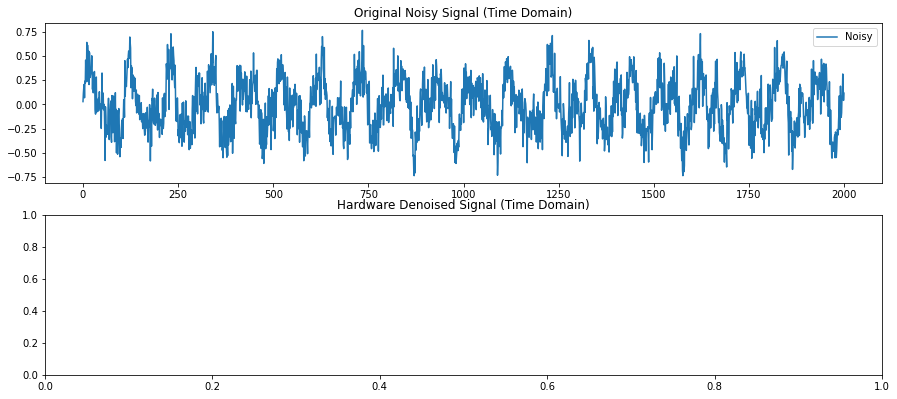

In [22]:
# 6. Visualization & Playback

plt.figure(figsize=(15, 10))

# Time Domain
plt.subplot(3, 1, 1)
plt.title("Original Noisy Signal (Time Domain)")
plt.plot(noisy_sig[:2000], label="Noisy")
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Hardware Denoised Signal (Time Domain)")
plt.plot(denoised_valid[:2000], color='green', label="Denoised")
plt.legend()

# Spectrogram Comparison
plt.subplot(3, 2, 5)
plt.specgram(noisy_sig, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Spectrogram: Noisy Input")
plt.ylabel("Frequency")

plt.subplot(3, 2, 6)
plt.specgram(denoised_valid, Fs=fs, NFFT=1024, noverlap=512)
plt.title("Spectrogram: Denoised Output")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print("Playing Denoised Audio:")
Audio(data=denoised_valid, rate=fs)

In [ ]:
# 7. Live Tuning (Optional)
# Use sliders to adjust alpha/beta and re-run

def update_denoise(alpha, beta):
    print(f"Running with Alpha={alpha}, Beta={beta}...")
    res = run_denoising_hardware(full_signal, alpha, beta)
    res_cut = res[preamble_len:]
    
    plt.figure(figsize=(10, 3))
    plt.plot(res_cut[:2000], color='green')
    plt.title(f"Result (Alpha={alpha}, Beta={beta})")
    plt.show()

widgets.interact(update_denoise, 
                 alpha=widgets.FloatSlider(min=0.5, max=5.0, step=0.1, value=2.5),
                 beta=widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.05));